In [1]:

import warnings
warnings.filterwarnings('ignore')
import datetime
from torch.utils.data import Dataset
from skimage.transform import resize
import cv2
from zipfile import ZipFile
import os
import torch

import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from Dataset import Dataset,Scale,ToTensor,visualize_loader
from Models.Facenet import save_model,Resnet34Triplet,load_model
from Models.Bisnet import BiSeNet,vis_parsing_maps
from losses import TripletLoss
import skimage
from skimage.io import imread,imsave
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm 
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import os
import shutil
import random
import pandas as pd
import torchvision.transforms as transforms



The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [69]:
temp=Discriminator()(torch.zeros((1,3,256,256)))#,torch.zeros((1,3,256,256)),torch.zeros((1,3,256,256)))
print(temp.size())


torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 4, 4])
torch.Size([1, 1, 4, 4])


In [50]:
a=nn.ConvTranspose2d(576, 512, 2, stride=1,\
                           padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros')
a2=nn.Conv2d(139,3,kernel_size=5,stride=1,padding=2)
t=a(torch.zeros((1,576,16,16)))
print(t.size())

torch.Size([1, 512, 17, 17])


torch.Size([1, 128, 64, 64])
torch.Size([1, 64, 16, 16])
torch.Size([1, 512, 17, 17]) torch.Size([1, 256, 32, 32])


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 17 and 32 in dimension 2 at /pytorch/aten/src/TH/generic/THTensor.cpp:689

In [ ]:
import pandas as pd
df=pd.read_csv('M2FPA_TRAIN.csv')
print(df.head(10))

In [ ]:
transform=torchvision.transforms.Compose([Scale(),ToTensor()])

train_dataset=Dataset('M2FPA_TRAIN.csv',transform)
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)

print(train_loader.__len__())

In [ ]:
input_img,gt_img=visualize_loader(train_loader,index=1)
plt.imshow(input_img);plt.show()
plt.imshow(gt_img);plt.show()

In [ ]:
print(input_img.shape)

In [2]:
model_parser=BiSeNet(19)
load_model('Weights/Parser.pth',model_parser)

Done loading


In [3]:
model_detect=Resnet34Triplet()
load_model('Weights/Facenet.pth',model_detect)

Done loading


# Generate Train and test data (Segregation)

In [ ]:
df=pd.read_csv('image_data.csv')
print(len(df))
df_train=pd.read_csv('train.csv')
print(len(df_train))
df_test=pd.read_csv('test.csv')
print(len(df_test))
print(len(df.Label.unique()))

In [ ]:
df_test.loc[df_test['Label']==15]

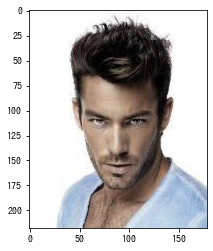

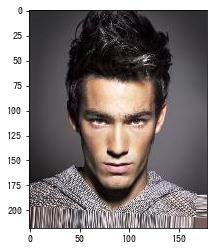

In [4]:
img=imread('img_align_celeba/013138.jpg')
img2=imread('img_align_celeba/118498.jpg')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

plt.imshow(img2);plt.show()
plt.imshow(img);plt.show()
img_tensor=img.transpose((2, 0, 1))
img2_tensor=img2.transpose((2, 0, 1))
img_tensor=np.expand_dims(img_tensor,axis=0)
img2_tensor=np.expand_dims(img2_tensor,axis=0)

img_tensor=torch.from_numpy(img_tensor).type(torch.FloatTensor).to(device)
img2_tensor=torch.from_numpy(img2_tensor).type(torch.FloatTensor).to(device)
model_detect=model_detect.to(device)

torch.Size([1, 3, 256, 256])
torch.Size([1, 19, 256, 256])


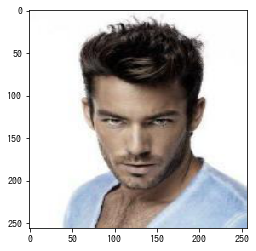

In [11]:
img2_model2=skimage.transform.resize(img2,(256,256))
img2_model2_raw=img2_model2
plt.imshow(img2_model2_raw)
to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

img2_model2 = to_tensor(img2_model2)
img2_model2 = torch.unsqueeze(img2_model2, 0)
img2_model2=img2_model2.type(torch.FloatTensor).to(device)


model_parser=model_parser.to(device)
model_parser.eval()
print(img2_model2.size())
temp,temp16,temp32,x=model_parser(img2_model2)
print(temp.size())

torch.Size([256, 256])
(256, 256, 3)


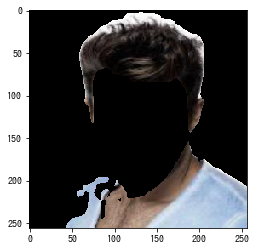

In [15]:
print(x[0].shape)
x_temp=x[2].detach().cpu().numpy()
print(img2_model2_raw.shape)

x_temp=np.repeat(np.expand_dims(x_temp,axis=2),3,axis=2)
plt.imshow(x_temp*img2_model2_raw)

In [14]:

print(x_temp2.shape)

(256, 256, 3)


In [7]:
!nvidia-smi

Fri Apr 24 22:43:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:B2:00.0 Off |                    0 |
| N/A   34C    P0    57W / 300W |   1510MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
print(temp.size())
x=torch.argmax(temp.squeeze(0),0)
x_detached=x.detach().cpu().numpy()
face=np.zeros(x.size())
face[x_detached==1]=1
plt.imshow(face)
eye_brow_right=np.zeros(x.size())


In [ ]:
a=torch.zeros_like(x)
print(torch.unique(a))

In [ ]:
parsing = torch.argmax(temp.squeeze(0),0)
print(torch.unique(parsing))
all_features=torch.zeros_like(parsing)
face_features=torch.zeros_like(parsing)
for i in range(len(torch.unique(parsing))+1):
    
    temp2=torch.zeros_like(parsing)
    temp2[torch.where(parsing==i)]=1
   
    if i in [2,3,4,5,10,12,13]:
        face_features+=temp2 
    if i!=0:
        all_features+=temp2
    if i==0:
        bg=temp2
    if i==1:
        face_skin=temp2
       
hair=(1-bg-all_features)
hair[torch.where(hair<0)]=1
plt.imshow(face_skin.detach().cpu().numpy());plt.show()
plt.imshow(hair.detach().cpu().numpy());plt.show()
plt.imshow(face_features.detach().cpu().numpy());plt.show()

[2,3,4,5,10,12,13]

In [ ]:
if 4 in [2,3,4]:
    print(4)

In [ ]:

            # print(parsing)
print(np.unique(parsing))

decoded=vis_parsing_maps(img2, parsing)

print(decoded.shape)
plt.imshow(decoded)

In [ ]:
parsing.shape

In [ ]:
plt.imshow(parsing)
print(parsing.shape)

In [ ]:
embedding=model(img_tensor)
embedding2=model(img2_tensor)
print(embedding-embedding2)
print(embedding)

In [ ]:

# label_list=list(set(df.Label))
# train_labels=random.sample(label_list,int(0.8*len(label_list)))
# test_labels=list(set(label_list)-set(train_labels))

# print(len(label_list),len(train_labels),len(test_labels))
# df_train=df[df.Label.isin(train_labels)]
# df_test=df[df.Label.isin(test_labels)]
# print(len(df),'\n',len(df_train),'\n',len(df_test))
# df_train.to_csv('train.csv',index=False)
# df_test.to_csv('test.csv',index=False)

# Light CNN


# PROBLEM WITH DATASET

In [ ]:
def visualize_loader(loader):
    for i,sample in enumerate(loader):
        #print(sample['image'].shape)
        if i==1:
            index=0
            
            image=(sample['image'][index]).numpy()
            
            
            #image=np.zeros(image_i.shape,dtype=np.uint8)
            #image[np.where(image_i!=0)]=255

            label=(sample['label'][index]).numpy()
            
            image=np.squeeze(image.transpose(1,2,0),axis=2)
            
            
            print(label)
            fig=plt.figure()
            plt.imshow(image,cmap='gray')
            
           
           
            break
visualize_loader(test_loader)

In [ ]:
block=resblock
model=network_29layers_v2(block, [1, 2, 3, 4])

model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'model_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('model_{} dir has been made'.format(model_start_date))
print("Model's state_dict:")
writer = SummaryWriter('model_{}/m2fpa_experiment_{}'.format(model_start_date,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())



In [ ]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))
optimizer_selected='adam'
batchsize=64
no_steps=train_dataset.__len__()//batchsize
restart_epochs=8
num_epochs=10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


criterion=TripletLoss(margin=8.4,device=device ,squared=False,batch_all=False)

model = model.to(device)



if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=10e-03, betas=(0.9, 0.98),weight_decay=0.02)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=10e-03, momentum=0.8,nesterov=True)

scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=10e-012, last_epoch=-1)

best_val=10e06
for epoch in range(num_epochs):
    loop=tqdm(train_loader)
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    

    for mode in ['train','eval']:
     
        if mode == 'train':
            
            running_loss = 0.0
            model.train()

            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                #print("epoch {},iter {}".format(epoch,i))

                # zero the parameter gradients

                optimizer.zero_grad()
                # get the inputs; data is a list of [inputs, labels]
                image_batch, labels_batch = sample_batched['image'],sample_batched['label']
                
                image_batch, labels_batch = image_batch.to(device, dtype = torch.float)\
                ,labels_batch.to(device, dtype = torch.float)

                # forward + backward + optimize
                
                embeddings_train=model(image_batch)
                #outputs = torch.sigmoid()
                
                loss = criterion(labels_batch,embeddings_train,)
        
                loss.backward()
                optimizer.step()
                
                scheduler.step()

                    
                loop.set_postfix(train_loss=loss.detach().item())
                
                 
                    
        elif mode =='eval':
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            final_test_loss=0
            
            for j, test_sample in enumerate(test_loader):
                
                optimizer.zero_grad()
                # get the inputs; data is a list of [inputs, labels]
                image_batch_test, label_batch_test = test_sample['image'],test_sample['label']
                image_batch_test, label_batch_test,neg_batch_test = image_batch_test.to(device, dtype = torch.float)\
                ,label_batch_test.to(device, dtype = torch.float)

                # forward + backward + optimize
                embeddings=model(image_batch_test)
                
                
                #outputs = torch.sigmoid()
                
                test_loss = criterion(label_batch_test,embeddings)
        
                
                final_test_loss+=test_loss.detach().item()
                
                if j%100==99:
                    writer.add_scalar('testing loss',test_loss.detach().item(),epoch * len(test_loader) + j)
                
            print("final test_loss: {}".format(final_test_loss/(j+1)))
            
            if final_test_loss/(j+1)<best_val:
                best_val=final_test_loss/(j+1)
                name=BEST_MODEL_PATH+'/model_optim.pth'
                save_model(model,optimizer,name,scheduler=None)
                print("saved model with test dice score: {}".format(best_val))

name=BEST_MODEL_PATH+'/model_final.pth'
save_model(model,optimizer,name,scheduler=None)
        
        

print('Finished Training')



# M2GAN

In [ ]:
class conv_block(nn.Module):
    def __init__(self,channel_in,channel_out,kernel_size,padding,stride):
        super().__init__()
        self.conv=nn.Sequential(nn.Conv2d(channel_in,channel_out,kernel_size=kernel_size,stride=stride,padding=padding,bias=True),
                                nn.BatchNorm2d(channel_out),
                                nn.ReLU(inplace=True))
    
    def forward(self,x):
        x=self.conv(x)
        return x

# class de_conv


In [ ]:

a = torch.randn(4, 4).to(device)
print(a.device)
torch.max(a, 1).values

In [ ]:
torch.max(torch.tensor([1.0]), torch.tensor([0.0]))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm as spectral_norm_fn
from torch.nn.utils import weight_norm as weight_norm_fn

class Conv2dBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding=0,
                 conv_padding=0, dilation=1, name='conv', weight_norm='sn', norm='none',
                 activation='relu', pad_type='zero', transpose=False):
        super(Conv2dBlock, self).__init__()
        self.use_bias = True
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        elif pad_type == 'none':
            self.pad = None
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        if weight_norm == 'sn':
            self.weight_norm = spectral_norm_fn
        elif weight_norm == 'wn':
            self.weight_norm = weight_norm_fn
        elif weight_norm == 'none':
            self.weight_norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(weight_norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        if transpose:
            self.conv = nn.ConvTranspose2d(input_dim, output_dim,
                                           kernel_size, stride,
                                           padding=conv_padding,
                                           output_padding=conv_padding,
                                           dilation=dilation,
                                           bias=self.use_bias)
        else:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride,
                                  padding=conv_padding, dilation=dilation,
                                  bias=self.use_bias)

        if self.weight_norm:
            self.conv = self.weight_norm(self.conv)

    def forward(self, x):
        if self.pad:
            x = self.conv(self.pad(x))
        else:
            x = self.conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

    
def gen_conv(input_dim, output_dim, kernel_size=3, stride=1, padding=0, rate=1,
             activation='elu'):
    return Conv2dBlock(input_dim, output_dim, kernel_size, stride,
                       conv_padding=padding, dilation=rate,
                       activation=activation)


def dis_conv(input_dim, output_dim, kernel_size=5, stride=2, padding=0, rate=1,
             activation='lrelu'):
    return Conv2dBlock(input_dim, output_dim, kernel_size, stride,
                       conv_padding=padding, dilation=rate,
                       activation=activation)


class Parser(nn.Module):
    def __init__(self): # config is not used..
        super().__init__()
        self.input_dim = 3
        self.class_num = 17      # (16 components + backgorund)
        self.cnum = 64
        

        # 128 * 128 * cnum
        self.conv1_1 = gen_conv(self.input_dim, self.cnum, 7, 1, 1)
        self.conv1_2 = gen_conv(self.cnum, self.cnum, 3, 2, 1)
        #--self.pool1

        # 64 * 64 * cnum
        self.conv2_1 = gen_conv(self.cnum, self.cnum * 2, 3, 1, 1)
        self.conv2_2 = gen_conv(self.cnum * 2, self.cnum * 2, 3, 2, 1)
        #--self.pool2

        # 32 * 32 * cnum
        self.conv3_1  = gen_conv(self.cnum * 2, self.cnum * 4, 3, 1, 1)
        self.conv3_2 = gen_conv(self.cnum * 4, self.cnum * 4, 3, 1, 1)
        self.conv3_3 = gen_conv(self.cnum * 4, self.cnum * 4, 3, 2, 1)
        #--self.pool3

        # 16 * 16 * cnum
        self.conv4_1 = gen_conv(self.cnum * 4, self.cnum * 8, 3, 1, 1)
        self.conv4_2 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv4_3 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 2, 1)
        #--self.pool4

        # 8 * 8 * cnum
        self.conv5_1 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv5_2 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 1, 1)
        self.conv5_3 = gen_conv(self.cnum * 8, self.cnum * 8, 3, 2, 1)
        #--self.pool5

        # 4 * 4 * cnum
        self.conv6_1 = gen_conv(self.cnum * 8, 4096, 3, 1, 1)


        #-- self.deconv6
        self.conv7_1  = gen_conv(4096, self.cnum * 8, 5, 1, 2)
        #-- dropout6

        # 8 * 8 * cnum
        #-- self.deconv7
        self.conv8_1 = gen_conv(self.cnum * 8, self.cnum * 8, 5, 1, 2)
        # -- dropout7

        # 16 * 16 * cnum
        #--self.deconv8
        self.conv9_1 = gen_conv(self.cnum * 8, self.cnum * 8, 5, 1, 2)
        # -- dropout8

        # 32 * 32 * cnum
        #-- self.deconv9
        self.conv10_1 = gen_conv(self.cnum * 8, self.cnum * 4, 5, 1, 2)
        # -- dropout9

        # 64 * 64 * cnum
        #--self.deconv10
        self.conv11_1 = gen_conv(self.cnum * 4, self.cnum * 2, 3, 1, 1)
        # -- dropout10

        # 128 * 128 * cnum
        #--self.deconv11
        self.conv12_1 = gen_conv(self.cnum * 2, self.cnum, 3, 1, 1)
        # -- dropout11

        # 128 * 128 * C+1 (FINAL)
        self.h_out = gen_conv(self.cnum, self.class_num, 3, 1, 1)

    def forward(self, x):

        # conv1
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)


        # conv2
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)


        # conv3
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv4
        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv5
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        #print(x.shape)
        #x = nn.MaxPool2d(x)

        # conv6
        x = self.conv6_1(x)
        #print(x.shape)

        # conv7
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv7_1(x)
        #print(x.shape)
        x = F.dropout2d(x)

        # conv8
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv8_1(x)
        #print(x.shape)

        # conv9
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv9_1(x)
        #print(x.shape)

        # conv10
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv10_1(x)
        #print(x.shape)

        # conv11
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv11_1(x)
        #print(x.shape)

        # conv12
        #x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv12_1(x)
        #print(x.shape)

        # h_out
        x_out = self.h_out(x)
        #print(x_out.shape)

        return x_out

In [ ]:
img2=imread('img_align_celeba/118498.jpg')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
temp_model=Parser().to(device)
img2_model2=skimage.transform.resize(img2,(512,512))
plt.imshow(img2_model2)
to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

img2_model2 = to_tensor(img2_model2)
img2_model2 = torch.unsqueeze(img2_model2, 0)
img2_model2=img2_model2.type(torch.FloatTensor)
img2_model2=img2_model2.to(device)
x=temp_model(img2_model2)
x.shape

In [ ]:
print(temp_model)